Création de bruit de différents types

In [1]:
import numpy as np
import os
import cv2
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy
   
my_img = cv2.imread('Torse.png')
cv2.imwrite('Torse_gaussian.png',
            noisy("gauss",my_img))

True

Création de bruit s&p

In [2]:
import random
import cv2
 
def add_noise(img):
 
    # Getting the dimensions of the image
    row , col = img.shape
     
    # Randomly pick some pixels in the
    # image for coloring them white
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
         
        # Color that pixel to white
        img[y_coord][x_coord] = 255
         
    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):
       
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
         
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
         
        # Color that pixel to black
        img[y_coord][x_coord] = 0
         
    return img
 
# salt-and-pepper noise can
# be applied only to grayscale images
# Reading the color image in grayscale image
img = cv2.imread('Torse.png',
                 cv2.IMREAD_GRAYSCALE)
 
#Storing the image
cv2.imwrite('Torse_s&p.png',
            add_noise(img))

True

Pré-traitement de l'image du torse avec plusieurs types d'algorithmes dans le cas d'un bruit s&p ou gaussien

C:\Users\julie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
C:\Users\julie\AppData\Local\Temp\ipykernel_15756\1346150682.py:77: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title("Gauss\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_gauss1,PSNR(original,blurred_img1),ssim_gauss1))
C:\Users\julie\AppData\Local\Temp\ipykernel_15756\1346150682.py:81: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title("Median\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_med1,PSNR(original,median_img1),ssim_med1))
C:\Users\julie\AppData\Local\Temp\ipykernel_15756\1346150682.py:85: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title("NLfastMean\n RMSE : 

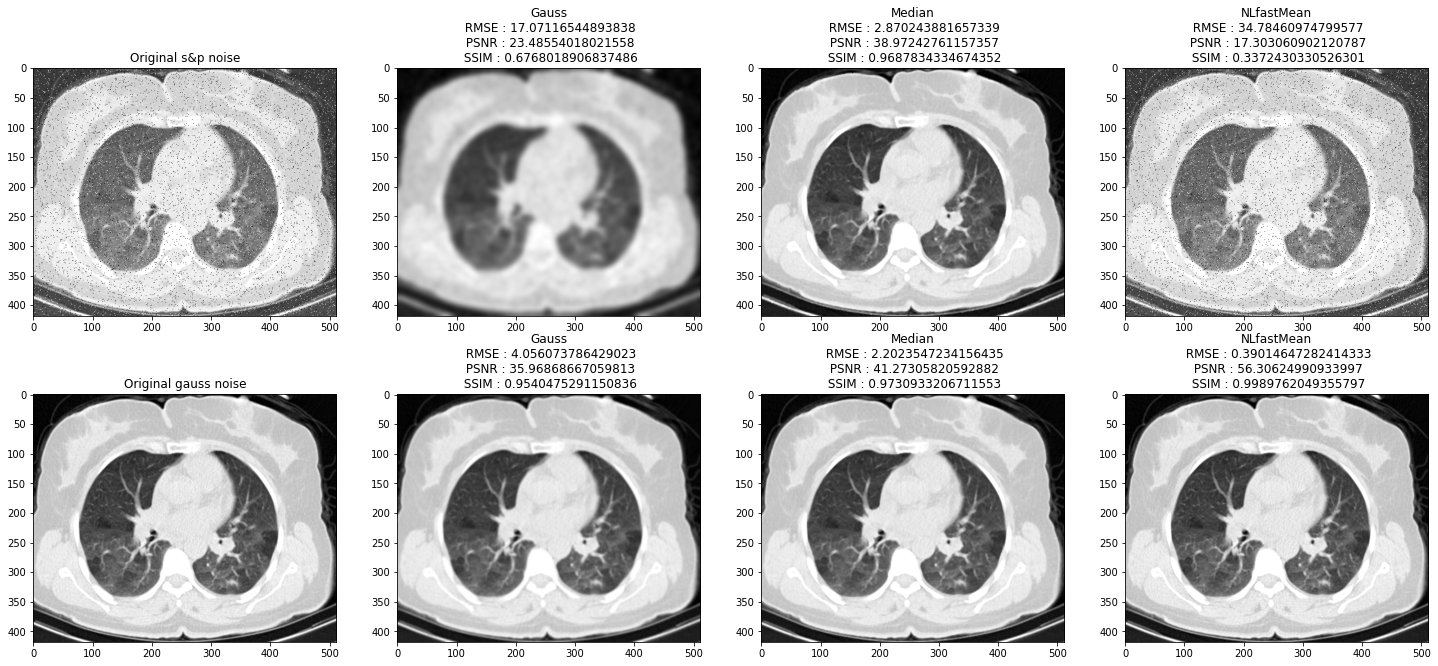

In [3]:
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.signal import convolve2d, wiener
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.restoration import denoise_wavelet, denoise_nl_means, estimate_sigma
import cv2

# Fonction pour le calcul du root mean square ratio (RMSE)
def RMSE(imageA, imageB):
    diffrnce = np.subtract(imageA, imageB)
    sqre_err = np.square(diffrnce)
    rslt_meansqre_err = sqre_err.mean()
    root_meansqre_err = math.sqrt(rslt_meansqre_err)
    return root_meansqre_err

# Ouverture de l'image du torse avec de bruit s&p
img1 = cv2.imread("Torse_s&p.png", 0)
img1 = img1.astype(float)

# Ouverture de l'image du torse avec de bruit gaussien
img2 = cv2.imread("Torse_gaussian.png", 0)
img2 = img2.astype(float)

# Ouverture de l'image original
original=cv2.imread("Torse.png", 0)

# Estimation du bruit de l'image
noise1 = estimate_sigma(img1)
noise2 = estimate_sigma(img2)

# Application d'un filtre gaussien
# Le filtre gaussian effectue une moyenne pondérée des valeurs du voisinage avec des poids élevés vers le centre puis qui diminue en s'écartant.
blurred_img1 = ndimage.gaussian_filter(img1, sigma=noise1)  
blurred_img2 = ndimage.gaussian_filter(img2, sigma=noise2)

# Application d'un filtre médian
# Fonctionnement filtre médian : Remplace l'entrée par la valeur médiane de ces voisins (window : généralement 3)
median_img1 = ndimage.median_filter(img1, 3)
median_img2 = ndimage.median_filter(img2, 3)

# Application d'un filtre moyen non local
# Fonction filtre nl_means : Prend le moyenne de l'ensemble des patchs de l'image, puis les pondère en fonction de la ressemblance avec le pixel cible
dst1 = denoise_nl_means(img1)
dst2 = denoise_nl_means(img2)

# Calcul du RMSE pour l'ensemble des images filtrées
RMSE_gauss1=RMSE(original, blurred_img1)
RMSE_gauss2=RMSE(original, blurred_img2)
RMSE_med1=RMSE(original, median_img1)
RMSE_med2=RMSE(original, median_img2)
RMSE_dst1=RMSE(original, dst1)
RMSE_dst2=RMSE(original, dst2)

# Calcul du "structural similarity index measure" (SSIM) pour l'ensemble des images filtrées
ssim_gauss1=ssim(original,blurred_img1)
ssim_gauss2=ssim(original,blurred_img2)
ssim_med1=ssim(original,median_img1)
ssim_med2=ssim(original,median_img2)
ssim_dst1=ssim(original,dst1)
ssim_dst2=ssim(original,dst2)

# Affichage de l'ensemble des images avec les métriques
fig = plt.figure()
fig.set_figheight(11)
fig.set_figwidth(25)

fig.add_subplot(2,4,1)
plt.imshow(img1, cmap='gray')
plt.title('Original s&p noise')

fig.add_subplot(2,4,2)
plt.imshow(blurred_img1, cmap='gray')
plt.title("Gauss\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_gauss1,PSNR(original,blurred_img1),ssim_gauss1))

fig.add_subplot(2,4,3)
plt.imshow(median_img1, cmap='gray')
plt.title("Median\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_med1,PSNR(original,median_img1),ssim_med1))

fig.add_subplot(2,4,4)
plt.imshow(dst1, cmap='gray')
plt.title("NLfastMean\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_dst1,PSNR(original,dst1),ssim_dst1))

fig.add_subplot(2,4,5)
plt.imshow(img2, cmap='gray')
plt.title('Original gauss noise')

fig.add_subplot(2,4,6)
plt.imshow(blurred_img2, cmap='gray')
plt.title("Gauss\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_gauss2,PSNR(original,blurred_img2),ssim_gauss2))

fig.add_subplot(2,4,7)
plt.imshow(median_img2, cmap='gray')
plt.title("Median\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_med2,PSNR(original,median_img2),ssim_med2))

fig.add_subplot(2,4,8)
plt.imshow(dst2, cmap='gray')
plt.title("NLfastMean\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_dst2,PSNR(original,dst2),ssim_dst2))
plt.show()


C:\Users\julie\AppData\Local\Temp\ipykernel_15756\2925474000.py:60: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title("Bayes\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_bayes1,PSNR(original,wavelet_bayes1),ssim_bayes1))
C:\Users\julie\AppData\Local\Temp\ipykernel_15756\2925474000.py:64: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title("Visu\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_visu1,PSNR(original,wavelet_visu1),ssim_visu1))
C:\Users\julie\AppData\Local\Temp\ipykernel_15756\2925474000.py:72: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title("Bayes\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_bayes2,PSNR(original,wavelet_bayes2),ssim_bayes2))
C:\Users\julie\AppData\Local\Temp\ipykernel_15756\2925474000.py:76: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title("Visu\n RMSE : {}\n PSNR : 

Text(0.5, 1.0, 'Visu\n RMSE : 1.5317944458885406\n PSNR : 44.426793798906495\n SSIM : 0.9835241374545116')

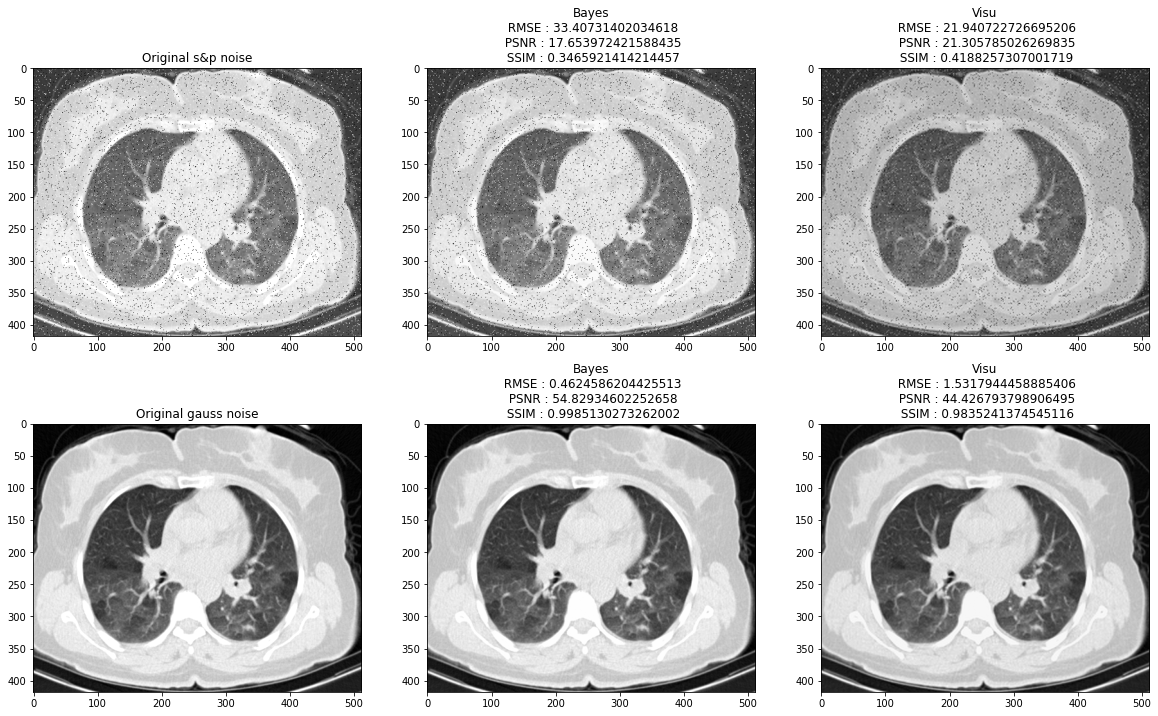

In [4]:
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.signal import wiener
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.restoration import denoise_wavelet

# Fonction pour le calcul du root mean square ratio (RMSE)
def RMSE(imageA, imageB):
    diffrnce = np.subtract(imageA, imageB)
    sqre_err = np.square(diffrnce)
    rslt_meansqre_err = sqre_err.mean()
    root_meansqre_err = math.sqrt(rslt_meansqre_err)
    return root_meansqre_err

# Ouverture de l'image du torse avec de bruit s&p
img1 = cv2.imread("Torse_s&p.png", 0)
img1 = img1.astype(float)

# Ouverture de l'image du torse avec de bruit gaussien
img2 = cv2.imread("Torse_gaussian.png", 0)
img2 = img2.astype(float)

# Ouverture de l'image du torse original
original=cv2.imread("Torse.png", 0)

# Application d'un filtre basée sur les ondelettes
# L'image est décomposé en ondelette avec chacun un coefficient associé, puis un seuil est appliqué pour éliminer les ondelette non désirées
wavelet_bayes1 = denoise_wavelet(img1, wavelet='sym9', method='BayesShrink')
wavelet_bayes2 = denoise_wavelet(img2, wavelet='sym9', method='BayesShrink')
wavelet_visu1 = denoise_wavelet(img1, wavelet='sym9', method='VisuShrink')
wavelet_visu2 = denoise_wavelet(img2, wavelet='sym9', method='VisuShrink')

# Calcul du RMSE pour l'ensemble des images filtrées
RMSE_bayes1=RMSE(original, wavelet_bayes1)
RMSE_bayes2=RMSE(original, wavelet_bayes2)
RMSE_visu1=RMSE(original, wavelet_visu1)
RMSE_visu2=RMSE(original, wavelet_visu2)

# Calcul du "structural similarity index measure" (SSIM) pour l'ensemble des images filtrées
ssim_bayes1=ssim(original,wavelet_bayes1)
ssim_bayes2=ssim(original,wavelet_bayes2)
ssim_visu1=ssim(original,wavelet_visu1)
ssim_visu2=ssim(original,wavelet_visu2)

# Affichage de l'ensemble des images avec les métriques
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(20)

fig.add_subplot(2,3,1)
plt.imshow(img1, cmap='gray')
plt.title('Original s&p noise')

fig.add_subplot(2,3,2)
plt.imshow(wavelet_bayes1, cmap='gray')
plt.title("Bayes\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_bayes1,PSNR(original,wavelet_bayes1),ssim_bayes1))

fig.add_subplot(2,3,3)
plt.imshow(wavelet_visu1, cmap='gray')
plt.title("Visu\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_visu1,PSNR(original,wavelet_visu1),ssim_visu1))

fig.add_subplot(2,3,4)
plt.imshow(img2, cmap='gray')
plt.title('Original gauss noise')

fig.add_subplot(2,3,5)
plt.imshow(wavelet_bayes2, cmap='gray')
plt.title("Bayes\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_bayes2,PSNR(original,wavelet_bayes2),ssim_bayes2))

fig.add_subplot(2,3,6)
plt.imshow(wavelet_visu2, cmap='gray')
plt.title("Visu\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_visu2,PSNR(original,wavelet_visu2),ssim_visu2))


Augmentation du contraste via une équalisation de contraste et du CLAHE

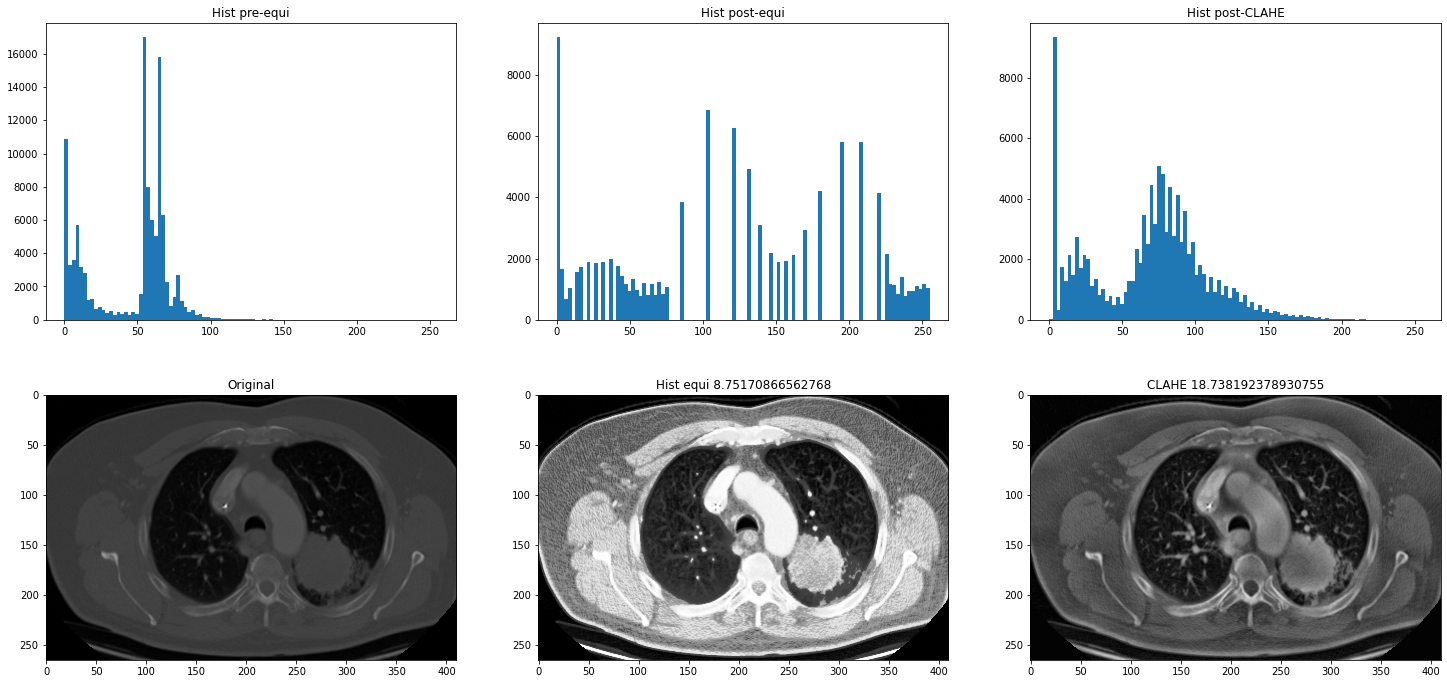

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as PSNR

# On ouvre l'image "Torse"
img = cv2.imread('Cancer.png',0)

# Application d'un équalisateur d'histogramme
# Il redonne via une formule mathématique une valeur pour chaque pixel afin d'utiliser l'ensemble des valeurs de pixel de manière la plus équitable possible
equ = cv2.equalizeHist(img)

# Application d'un CLAHE
# Contrast Limited Adaptive Histogram Equalization (CLAHE) : l'image est divisés en blocs sur lequels une équalisation d'histogramme est effectué.
# Une limite de contrast est aussi définie. Si une case de l'histogramme dépasse le valeur limite alors les valeurs en excès sont accumulées et redistribuées dans d'autres cases
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16,16))
cl1 = clahe.apply(img)

# Affichage de l'ensemble des images avec les métriques
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(25)

fig.add_subplot(2,3,1)
plt.hist(img.flat, bins=100, range=(0,255))
plt.title('Hist pre-equi')

fig.add_subplot(2,3,2)
plt.hist(equ.flat, bins=100, range=(0,255))
plt.title('Hist post-equi')

fig.add_subplot(2,3,3)
plt.hist(cl1.flat, bins=100, range=(0,255))
plt.title('Hist post-CLAHE')

fig.add_subplot(2,3,4)
plt.imshow(img, cmap='gray')
plt.title('Original')

fig.add_subplot(2,3,5)
plt.imshow(equ, cmap='gray')
plt.title('Hist equi {}'.format(PSNR(img,equ)))

fig.add_subplot(2,3,6)
plt.imshow(cl1, cmap='gray')
plt.title('CLAHE {}'.format(PSNR(img,cl1)))

plt.show()        